In [99]:
import pandas as pd
import re
import numpy as np
# import matplotlib.pyplot as plt
import ftfy  # Fixes text encoding issues
from emoji import is_emoji
from nltk.tokenize import TweetTokenizer

# import swifter

import emoji, re
from nltk.corpus import stopwords


In [100]:
fp = r"C:\Users\Clover\Documents\GitHub\DVA_Team_173\data_full\raw\twitter_data\kaggle\tweets_kaggle_labelled.csv"
df = pd.read_csv(fp)
df.head(1)  # Display first 5 rows


,id,created_at,full_text,predicted_score
0,1,2020-04-09 23:59:51+00:00,@KennyDegu very very little volume. With $10T ...,-0.637271


In [101]:

# Function to extract stock tickers
def extract_tickers(text):
    tickers = re.findall(r'\$[A-Za-z]+', str(text))  # Find tickers with "$"
    tickers = [t.replace("$", "").upper() for t in tickers]  # Remove "$" and uppercase
    return tickers if tickers else None  # Return None if no tickers found

# Apply function to create new columns
df["stock_ticker"] = df["full_text"].apply(extract_tickers)
df["num_stocks"] = df["stock_ticker"].apply(lambda x: len(x) if x else 0)  # Count number of tickers

# Save the updated file (optional)
# df.to_csv("tweets_kaggle_labelled_with_tickers2.csv", index=False)

# Show sample output
# print(df[["full_text", "stock_ticker", "num_stocks"]].head())
# df.head()


In [102]:

def filter_by_stock(df, stock_list):
    """
    Filters a DataFrame to retain rows where stock_ticker contains 
    at least one stock from stock_list.

    Args:
    df (pd.DataFrame): The input DataFrame with a 'stock_ticker' column.
    stock_list (list): List of stock tickers to filter.

    Returns:
    pd.DataFrame: Filtered DataFrame.
    """
    # Ensure stock_ticker is a list (handling NaNs)
    return df[df['stock_ticker'].apply(lambda x: isinstance(x, list) and any(ticker in stock_list for ticker in x))]

# Example usage
# stock_list = ['AAPL', 'IVDA','TSLA','NVDA','MSFT']
stock_list = ['AAPL']
filtered_df = filter_by_stock(df, stock_list)
filtered_df

,id,created_at,full_text,predicted_score,stock_ticker,num_stocks
9,13,2020-04-09 23:56:58+00:00,RT @TDANetwork: 📽️ #TheWatchList panel assesse...,-0.530650,[AAPL],1
10,14,2020-04-09 23:56:51+00:00,$UMRX bouncing. EXTREMELY OVERSOLD #Coronaviru...,-1.029604,"[UMRX, DECN, OPGN, CODX, HTBX, TNXP, BA, APRN,...",40
28,32,2020-04-09 23:55:05+00:00,$AAPL 4h/1h\n\nSometimes these wedges break hi...,0.561125,[AAPL],1
29,33,2020-04-09 23:54:47+00:00,This week's Expired Signals are now published ...,0.032285,"[TGT, DG, MCD, EMB, CMCSA, AMZN, AAPL, SPY, EU...",15
30,34,2020-04-09 23:54:28+00:00,"$SPY $QQQ $VXX $AAPL $BA $MSFT\n\nGuys, I figu...",-0.019171,"[SPY, QQQ, VXX, AAPL, BA, MSFT]",6
...,...,...,...,...,...,...
919941,10083,2020-04-09 11:40:05+00:00,$AAPL cycle from Feb peak managed to reach the...,0.933559,[AAPL],1
919943,10085,2020-04-09 11:40:02+00:00,$AAPL 1 hour view from 3/20 update presented t...,0.499091,[AAPL],1
919966,10108,2020-04-09 11:37:38+00:00,Great trade ideas every day in the room! Join ...,0.941858,"[SPY, SPX, IWM, NFLX, AMZN, AAPL, FB, TTD, GOO...",28
919978,10120,2020-04-09 11:36:50+00:00,I See A Slight Decline In The Daily US Death I...,-0.048247,"[AAPL, AMZN, AGN, BRK, BA, BHC, CRM, CMG, DIS,...",27


In [103]:
filtered_df.shape

(70012, 6)

In [104]:
# Shrink dataset to just 1k rows for testing/dev purposes
df = filtered_df.copy()

In [105]:
# df['full_text'] = df['full_text'].apply(lambda x: ftfy.ftfy(x))
# df

In [106]:
tokenizer = TweetTokenizer()
cashtag_rx = re.compile(r'\$[A-Za-z]+')  # Regex for cash tags
stops = stopwords.words('english')

def myTweetTokenizer(tweet): # tweet = string representation of text
    tweet = re.sub(cashtag_rx,'cash_tag',tweet) # normalize cash tags
    toks = tokenizer.tokenize(tweet) # get list of tokens
    good_tokens = []
    for tok in toks:
        
        # Check if the token is an emoji
        if emoji.is_emoji(tok):
            continue #ignores emojis
        elif tok=='cash_tag':
            continue        
        elif len(tok)>=3 and tok.isalpha():
            good_tokens.append(tok.lower())  

        elif tok.startswith("#"):
            continue
            # good_tokens.append(tok.lower()) # convert the words to lowercase hastags
        else:
            continue
    
    return good_tokens

# Test
# print(sample)
# myTweetTokenizer(sample)




In [107]:
import re
from emoji import is_emoji
from nltk.tokenize import TweetTokenizer
import pandas as pd

tokenizer = TweetTokenizer()
cashtag_rx = re.compile(r'\$[A-Za-z]+')  # Regex to detect cash tags

def normalizeToken(token):
    lowercased_token = token.lower()
    if token.startswith("@"):  # Normalize mentions
        return "@USER"
    elif lowercased_token.startswith("http") or lowercased_token.startswith("www"):  # Normalize URLs
        return "HTTPURL"
    elif cashtag_rx.match(token):  # Normalize cash tags
        return "cash_tag"
    elif is_emoji(token):  # Preserve emojis
        return token
    elif token.startswith("#"):  # Convert hashtags to lowercase
        return lowercased_token
    elif len(token) >= 3 and token.isalpha():  # Keep only meaningful words (length >= 3)
        return lowercased_token
    elif token == "’":
        return "'"
    elif token == "…":
        return "..."
    else:
        return None  # Filter out other tokens

def normalizeTweet(tweet):
    tweet = re.sub(cashtag_rx, "cash_tag", tweet)  # Normalize cash tags in the tweet text
    tokens = tokenizer.tokenize(tweet.replace("’", "'").replace("…", "..."))
    
    good_tokens = []  # Initialize the list to store good tokens
    for token in tokens:
        normalized_token = normalizeToken(token)
        if normalized_token:  # Append only non-None tokens
            good_tokens.append(normalized_token)
    
    return good_tokens  # Return the list of good tokens

# Example DataFrame setup
data = {'full_text': ["Hello @world! Check out http://example.com #amazing 😊 $STOCK", 
                      "Another example tweet with a #hashtag and $CASH"]}
df_test = pd.DataFrame(data)

# Apply the function to each row's 'full_text' and store the results in a new column
df_test['good_tokens'] = df_test['full_text'].apply(normalizeTweet)

print(df_test[['full_text', 'good_tokens']])

                                           full_text  \
0  Hello @world! Check out http://example.com #am...   
1    Another example tweet with a #hashtag and $CASH   

                                        good_tokens  
0  [hello, @USER, check, out, HTTPURL, #amazing, 😊]  
1    [another, example, tweet, with, #hashtag, and]  


In [43]:
# df['full_text'] = df['full_text'].apply(normalizeTweet)

# df['full_text'] = df['full_text'].swifter.apply(normalizeTweet)
# df['full_text']


In [108]:
count_vec = CountVectorizer(lowercase = False, tokenizer = myTweetTokenizer, ngram_range = (1,2), max_features = 2000, stop_words = stops)
tfidf_vec = TfidfVectorizer(lowercase = False, tokenizer = myTweetTokenizer, ngram_range = (1,2), max_features = 2000, stop_words = stops)

dtm_c = count_vec.fit_transform(df['full_text'])
dtm_w = tfidf_vec.fit_transform(df['full_text'])

c:\Users\Clover\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [109]:
dtm_c

<70012x2000 sparse matrix of type '<class 'numpy.int64'>'
	with 674360 stored elements in Compressed Sparse Row format>

In [110]:
vocab_c = np.asarray(count_vec.get_feature_names_out())
vocab_w = np.asarray(tfidf_vec.get_feature_names_out())

topn = 10
print(f"{topn} most common words based on word counts:\n")

# convert to dense matrix, sum by column, see which words most prevalent using argsort(), grabbing top10, flipping them to see most frequent words first
words = vocab_c[np.asarray(dtm_c.todense()).sum(axis=0).argsort()[-topn:][::-1]]
print(", ".join(words))

print("\n")

print(f"{topn} most common words based on weighted counts:\n")
words = vocab_w[np.asarray(dtm_w.todense()).sum(axis=0).argsort()[-topn:][::-1]]
print(", ".join(words))


10 most common words based on word counts:

today, apple, day, market, stock, week, stocks, short, trade, buy


10 most common words based on weighted counts:

today, day, apple, market, stock, week, short, red, stocks, buy


In [111]:
in_c_not_w = [w for w in vocab_c if w not in vocab_w]
in_w_not_c = [w for w in vocab_w if w not in vocab_c]

len(in_w_not_c)

0

In [112]:
# use a set union, anyover lap would see something more than 2000 words
len(set(vocab_c).union(vocab_w))

2000

In [113]:
from sklearn.model_selection import train_test_split

# count-based dtm, weighted dtm, and sentiment score = y variable

c_train,c_test,w_train,w_test,y_train,y_test = train_test_split(dtm_c, dtm_w, df['predicted_score'],train_size=0.80,random_state=123)

In [114]:
y_train.shape

(56009,)

In [115]:
y_test.shape

(14003,)

In [116]:
from sklearn.linear_model import Lasso, LinearRegression as OLS

lasso = Lasso(alpha=0.1, selection="random", random_state=123)

# In linear model, OLS is single best estimate, maximum likelihood
ols = OLS()
lasso.fit(w_train,y_train)
ols.fit(w_train,y_train)

LinearRegression()

In [117]:
from sklearn.metrics import r2_score, mean_squared_error

# OLS
# R2 & MSE of trained OLS model
print(r2_score(y_train,ols.predict(w_train)))
print(mean_squared_error(y_train,ols.predict(w_train)))

0.010628031217620015
0.4724638281237272


In [118]:

# Lasso model
# R2 & MSE of trained Lasso model
# Lasso is zero because it's overregularized, everything coeffiecient is driven to zero
print(r2_score(y_train,lasso.predict(w_train)))
print(mean_squared_error(y_train,lasso.predict(w_train)))

0.0
0.47753912889323963


In [119]:
# OLS went from 0.46 to 0.44, OLS model is not overfitted,not relying on too many features 

print(mean_squared_error(y_test,ols.predict(w_test)))
print(mean_squared_error(y_test,lasso.predict(w_test)))

0.4915275068821046
0.4866489300632641


In [120]:
from sklearn.model_selection import GridSearchCV, KFold

# Tuning Lasso model to improve MSE 
# GridSearchCV is used to find the best hyperparameters
# KFold is used to split the data into 5 folds
alphas = [i/100000 for i in range(1,10001,100)]
params = {'alpha':alphas,'random_state':[123]}
len(alphas)

100

In [121]:
alphas[-10:]

[0.09001,
 0.09101,
 0.09201,
 0.09301,
 0.09401,
 0.09501,
 0.09601,
 0.09701,
 0.09801,
 0.09901]

In [122]:
lasso = Lasso()

gs = GridSearchCV(lasso,params, scoring = ['neg_root_mean_squared_error','r2'],cv=3,n_jobs=-1,refit=False) # refit needs to be false since we have multiple metrics

# Now we fit the model using the same process as before:
gs.fit(w_train,y_train)

GridSearchCV(cv=3, estimator=Lasso(), n_jobs=-1,
             param_grid={'alpha': [1e-05, 0.00101, 0.00201, 0.00301, 0.00401,
                                   0.00501, 0.00601, 0.00701, 0.00801, 0.00901,
                                   0.01001, 0.01101, 0.01201, 0.01301, 0.01401,
                                   0.01501, 0.01601, 0.01701, 0.01801, 0.01901,
                                   0.02001, 0.02101, 0.02201, 0.02301, 0.02401,
                                   0.02501, 0.02601, 0.02701, 0.02801, 0.02901, ...],
                         'random_state': [123]},
             refit=False, scoring=['neg_root_mean_squared_error', 'r2'])

In [123]:
gs.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_alpha', 'param_random_state', 'params', 'split0_test_neg_root_mean_squared_error', 'split1_test_neg_root_mean_squared_error', 'split2_test_neg_root_mean_squared_error', 'mean_test_neg_root_mean_squared_error', 'std_test_neg_root_mean_squared_error', 'rank_test_neg_root_mean_squared_error', 'split0_test_r2', 'split1_test_r2', 'split2_test_r2', 'mean_test_r2', 'std_test_r2', 'rank_test_r2'])

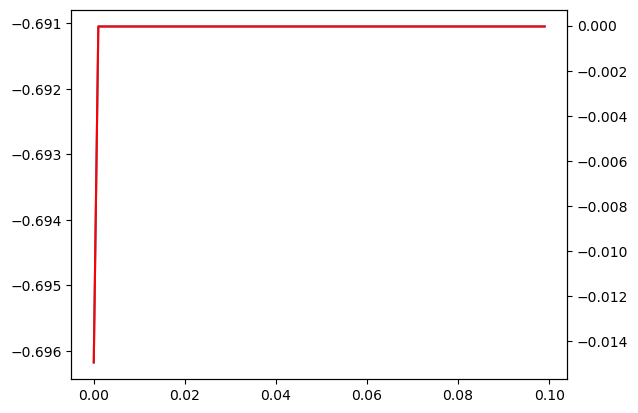

In [124]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots(1,1)
ax2 = ax.twinx()

ax.plot(gs.cv_results_['param_alpha'],gs.cv_results_['mean_test_neg_root_mean_squared_error'])
ax2.plot(gs.cv_results_['param_alpha'],gs.cv_results_['mean_test_r2'],color='red')

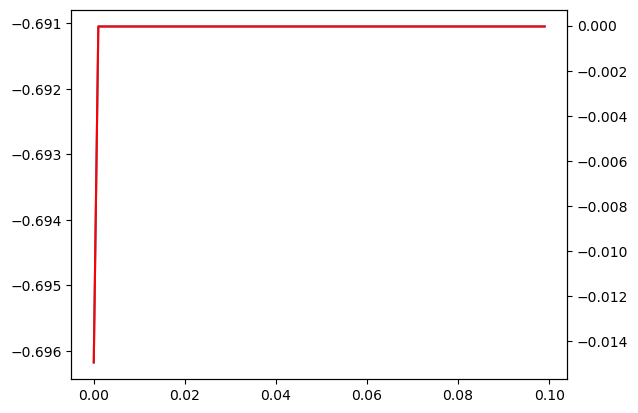

In [125]:
fig,ax = plt.subplots(1,1)
ax2 = ax.twinx()
ax.plot(gs.cv_results_['param_alpha'][:500],gs.cv_results_['mean_test_neg_root_mean_squared_error'][:500])
ax2.plot(gs.cv_results_['param_alpha'][:500],gs.cv_results_['mean_test_r2'][:500],color='red')

In [126]:
max_r2 = gs.cv_results_['mean_test_r2'].argmax()
print(max_r2)
print(f"The alpha that produces the maximum R2 (and minimum MSE) is {gs.cv_results_['param_alpha'][max_r2]}.")

1
The alpha that produces the maximum R2 (and minimum MSE) is 0.00101.


In [127]:
lasso = Lasso(alpha=gs.cv_results_['param_alpha'][max_r2],
              random_state=123)
lasso.fit(w_train,y_train)

print(mean_squared_error(y_test,ols.predict(w_test)))
print(mean_squared_error(y_test,lasso.predict(w_test)))

0.4915275068821046
0.4866489300632641


In [128]:
# 88 out of 2000 were zero coefficient, penalized or regularized to zero: 

len([c for c in lasso.coef_ if c==0])

2000

In [129]:
# in OLS every single coefficient was NOT zero
len([c for c in ols.coef_ if c==0])

0

In [130]:
# Significant predictors

topn = 20
abs_coef = np.abs(lasso.coef_)
top20 = np.argsort(abs_coef)[-topn:][::-1]
print(f"The {topn} words and phrases most relevant for predicting sentiment are as follows")

for w in top20:
    print(f"Word: {vocab_w[w]} had a coefficient of {lasso.coef_[w]}.")

The 20 words and phrases most relevant for predicting sentiment are as follows
Word: zoom had a coefficient of -0.0.
Word: interesting had a coefficient of -0.0.
Word: increases had a coefficient of 0.0.
Word: increases april had a coefficient of 0.0.
Word: index had a coefficient of 0.0.
Word: indexes had a coefficient of -0.0.
Word: industry had a coefficient of 0.0.
Word: industry activity had a coefficient of 0.0.
Word: inexpensive had a coefficient of 0.0.
Word: inexpensive ventilator had a coefficient of 0.0.
Word: insane had a coefficient of 0.0.
Word: installed had a coefficient of -0.0.
Word: instead had a coefficient of -0.0.
Word: instinet had a coefficient of -0.0.
Word: interest had a coefficient of 0.0.
Word: inventory had a coefficient of 0.0.
Word: jerome had a coefficient of -0.0.
Word: inventory laptops had a coefficient of 0.0.
Word: inverse had a coefficient of 0.0.
Word: investing had a coefficient of -0.0.
